<a href="https://colab.research.google.com/github/catalinapesquet/PINNS-Code-and-Notes/blob/main/PINNS_DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

pyDOE is designed to help the scientist, engineer, statistician, etc., to construct appropriate experimental designs.: https://pythonhosted.org/pyDOE/

In [2]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=386573c1889deae96db9aca828f5c85556ef3a26857eb5a45baa308bbeccde3e
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [3]:
import torch
import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn # neural networks
import torch.optim as optim # optimizers

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs # Latin Hypercube Sampling
import scipy.io

In [4]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


## Parameters

In [5]:
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers

# To generate new data:
x_min = -1
x_max = 1
t_min = 0
t_max = 1
total_points_x = 200
total_points_t = 100

#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu = 100
Nf = 10000

# **Auxiliary Functions**

In [6]:
def plot3D(x, t, y):
    # Prepare meshgrid and data
    x_plot = x.squeeze(1)
    t_plot = t.squeeze(1)
    T, X = torch.meshgrid(x_plot, t_plot, indexing='ij')
    F_xt = y

    # Convert to numpy
    T_numpy = T.numpy()
    X_numpy = X.numpy()
    F_xt_numpy = F_xt.numpy()

    # Check for invalid values
    if torch.isnan(F_xt).any() or torch.isinf(F_xt).any():
        F_xt = torch.nan_to_num(F_xt, nan=0.0, posinf=1e6, neginf=-1e6)

    # 2D Contour Plot
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(T_numpy, X_numpy, F_xt_numpy, levels=20, cmap="rainbow")
    fig.colorbar(cp)
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

    # 3D Surface Plot
    ax = plt.axes(projection='3d')
    ax.plot_surface(T_numpy, X_numpy, F_xt_numpy, cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()


In [7]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

# **Problem Setup**

Diffusion equation:
$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

Initial Condition
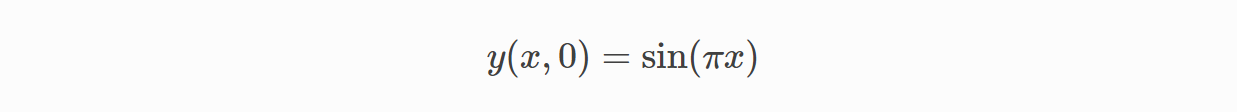
Boundary Conditions
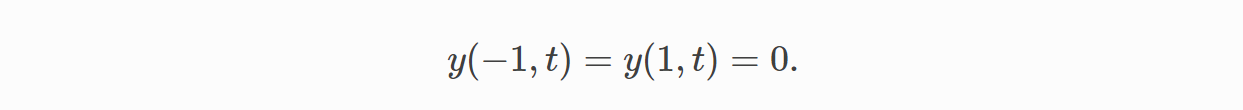
Exact solution (to evaluate the model)
$$y(x,t)=e^{-t}sin(\pi x)$$

# Analysis

## PDE
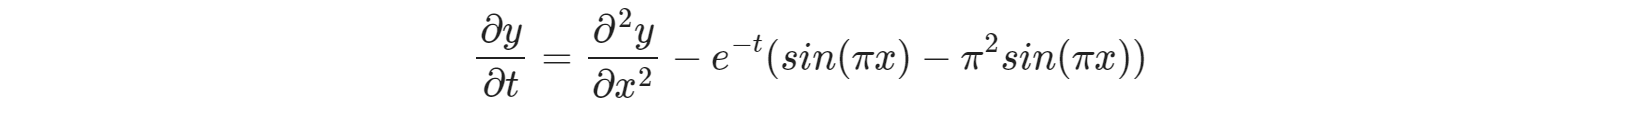
If we re arrange our PDE:
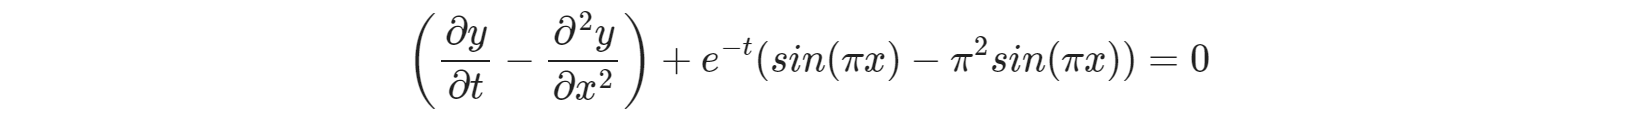

## Neural Network

A Neural Network is a function:
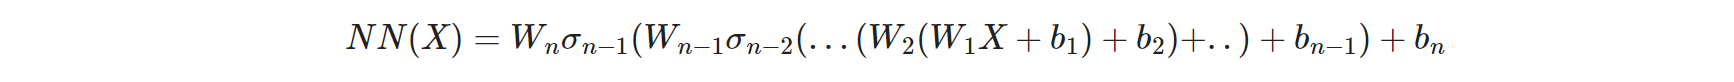

Assume:
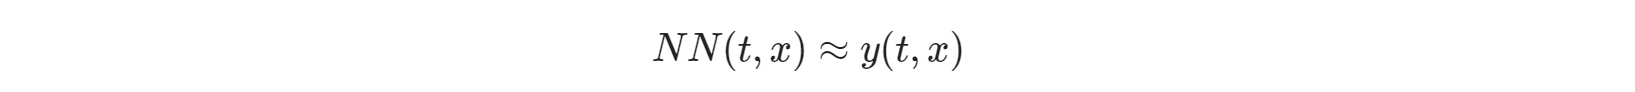

Then:
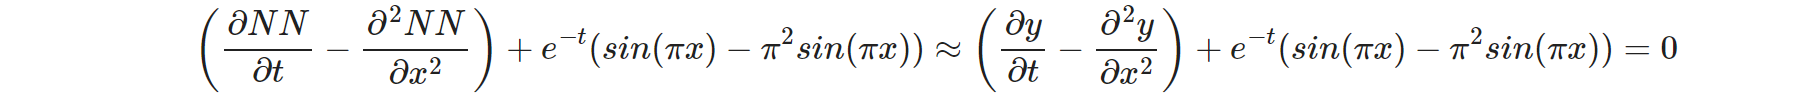

We define this function f:
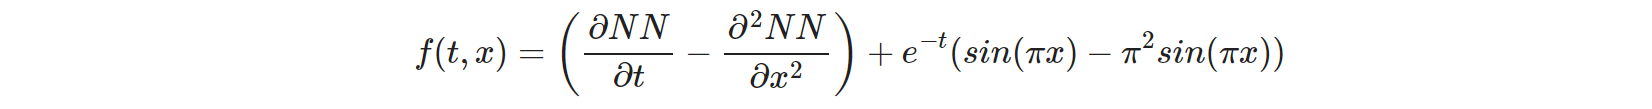

If $f$ -> 0, then our NN would be respecting the physical law.

## PDE Loss function

We evaluate our PDE in a certain number of "collocation points" $(Nf)$ inside our domain $(x,t)$
. Then we iteratively minimize a loss function related to $f$:
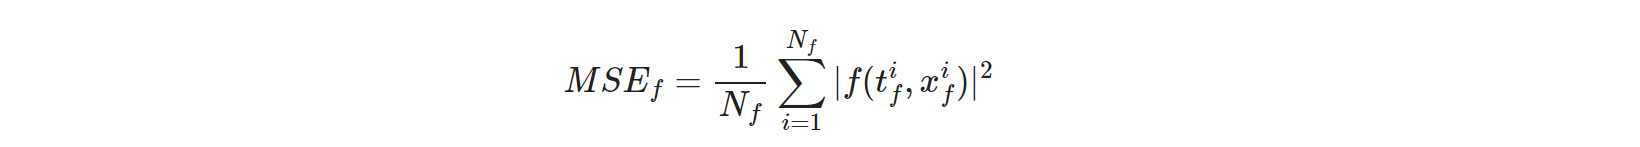

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

### Initial condition
$y(x,0)=sin(\pi x)$

### Boundary Conditions
$y(-1,t)=0$

$y(1,t)=0$

Since we know the outcome, we select $Nu$ points from our BC and IC and used them to train our network.
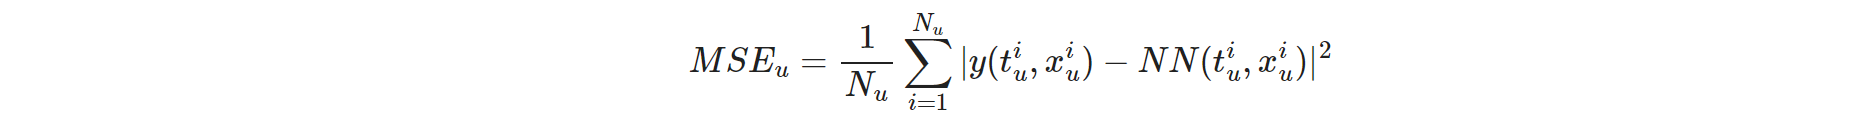

## Total Loss
Sum of loss from boundaries and loss from partial differential equation.
$MSE= MSEu + MSEf$



# **Generate and Visualize the DATA**

## Function

In [8]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

## Generate data

In [9]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)

## Create Mesh
Now let's generate a mesh using meshgrid: https://pytorch.org/docs/stable/generated/torch.meshgrid.html

In [10]:
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
y_real = f_real(X,T)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)

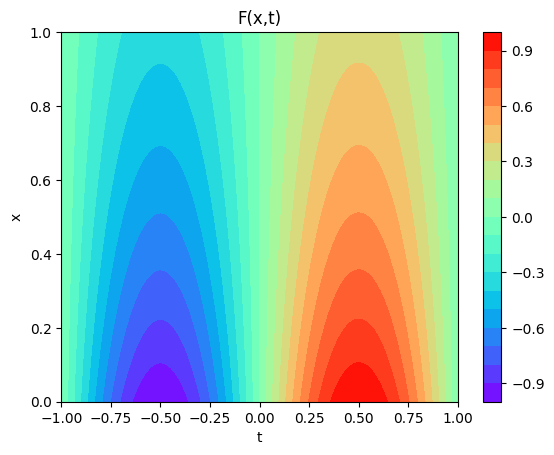

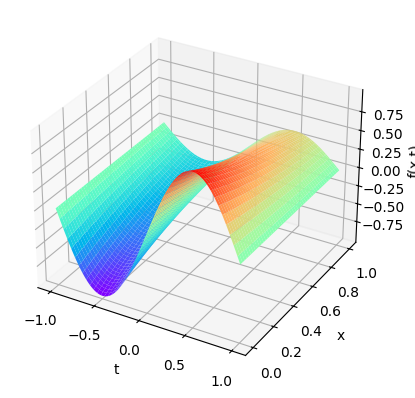

In [12]:
plot3D(x,t,y_real) #f_real was defined previously(function)

In [13]:
print(x.shape, t.shape, y_real.shape)
print(X.shape, T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


# Testing Data

In [14]:
# Transform the mesh into a 2-column vector
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None]

In [15]:
# Domain bounds
lb = x_test[0] # lower bound
ub = x_test[-1] # upper bound

print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


# Training Data

Training data are boundary conditions

In [16]:
left_x = torch.hstack((X[:,0][:, None],T[:,0][:, None])) # all the rows and only first column
left_y = torch.sin(np.pi*left_x[:,0]).unsqueeze(1)

bottom_x = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))
bottom_y = torch.zeros(bottom_x.shape[0],1)

top_x = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_y = torch.zeros(top_x.shape[0],1)

In [17]:
X_train = torch.vstack([left_x, bottom_x, top_x])
y_train = torch.vstack([left_y, bottom_y, top_y])

Select a certain amount of points

In [18]:
Nu = 100 # 100 points from the boundary points
idx = np.random.choice(X_train.shape[0], Nu, replace=False)

X_train_Nu = X_train[idx,:]
Y_train_Nu = y_train[idx,:]

Collocation points

In [19]:
Nf = 1000
X_train_Nf = lb + (ub-lb)*lhs(2,Nf)
X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))

In [20]:
X_train_Nu = X_train_Nu.float().to(device)
Y_train_Nu = Y_train_Nu.float().to(device)
X_train_Nf = X_train_Nf.float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

# Neural Network


In [21]:
class FCN(nn.Module):
  def __init__(self, layers):
    super().__init__() # call __init__ from parent class
    'activation function'
    self.activation = nn.Tanh()
    'loss function'
    self.loss_function = nn.MSELoss(reduction='mean')
    'Initialise neural network as a list using nn.Modulelist'
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    'Initialise our weights'
    for i in range(len(layers)-1):
      # initialise weights with xavier normalisation
      nn.init.xavier_normal(self.linears[i].weight.data, gain=1.0)
      # set bias to zero
      nn.init.zeros_(self.linears[i].bias.data)

  def forward(self, x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    for i in range(len(layers)-2):
      z = self.linears[i](a)
      a = self.linears[-1](a)
    a = self.linears[-1](a)
    return a

  def lossBC(self, x_BC, y_BC):
    loss_BC = self.loss_function(self.forward(x_BC), y_BC)
    return loss_BC

  def lossPDE(self, x_PDE):
    g = x_PDE.clone()
    g.requires_grad = True # Enable differentiation
    f.self.forward(g)
    f_x_t = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(device),retain_graph=True, create_graph=True)[0] # first derivative
    f_xx_tt = autograd.grad(f_x_t, g, torch.ones(g.shape).to(device), create_graph=True)[0] # second derivative
    f_xx = f_xx_tt[:, [0]] # select the 2nd element for t (the first one is x)
    f = f_t - f_xx + torch.exp(-g[:, 1:]) * (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch)
    return self.loss_function(f, f_hat)

  def loss(self, x_BC, y_BC, x_PDE):
    loss_bc = self.lossBC(x_BC, y_BC)
    loss_pde = self.lossPDE(x_PDE)
    return loss_bc + loss_pde

  # optimizer
  def closure(self):
      optimizer.zero_grad()
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss
